In [61]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import random
import os
import math

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
def plot_curves(title, data, y_title, x_title='Epoch', legend=[], x_labels_offset = 0):
    fig = plt.figure(figsize=(8, 4))
        
    for row in data:
        x = range(x_labels_offset, len(row))
        plt.plot(x, row[x_labels_offset:])
    
    plt.title(title)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.grid(True)
    plt.legend(legend, loc='upper left')
    plt.show()

In [3]:
def predicted_to_df_and_to_file(predicted, filename):    
    ids = []
    values = []
    
    for idx, val in enumerate(predicted):
        ids.append(idx + 1)
        values.append(val[0])
    
    df = pd.DataFrame({'id': ids, 'label': values})
    
    df.to_csv(f"{filename}_submission.csv", index=False, float_format='%.3f')
    
    return df

In [4]:
prepared_path = './data/prepared'

In [5]:
WIDTH = 180
HEIGHT = 180
IMG_SIZE = (WIDTH, HEIGHT)
CHANNELS = 3

In [6]:
test_data_path = './data/test'
test_files = os.listdir(test_data_path)
test_data = []
for test_file in test_files:
    full_path = f'{test_data_path}/{test_file}'
    img_data = img_to_array(load_img(full_path, target_size=IMG_SIZE))
    test_data.append(img_data)

test_data = np.array(test_data) / 255
#test_data = test_data[: 1000]
test_data.shape

(12500, 180, 180, 3)

In [71]:
class BaseModel():
    def __init__(self):
        self.init_basic_params()
        
        self.compile()
        
        self.tf_writer.add_graph(self.session.graph)
    
    def rand_str(self, str_len=20):
        return ''.join(random.choices(string.ascii_uppercase + string.digits, k=str_len))
    
    def init_basic_params(self):
        tf.reset_default_graph()
        self.logs_path = './tf_board/' + self.__class__.__name__
        self.var_scope = self.rand_str()
        self.print_separator = '-' * 65
        self.session = None
        self.dropout_rate_tf = tf.placeholder(tf.float32)
        
        self.input_size = [WIDTH, HEIGHT, CHANNELS]
        self.output_size = 1
        
        self.dropout_rate = 0.15
        
        self.start_learning_rate = 0.01
        
        self.tf_writer = tf.summary.FileWriter(self.logs_path)
    
    def __del__(self): 
        print('object del')
        if self.session:
            tf.reset_default_graph()
            self.session.close()
    
    def reset_internal_params(self):
        self.hidden_layers = {}
        self.hidden_layers_W = {}
        self.hidden_layers_b = {}
        self.history = {
            'acc_train': [],
            'acc_valid': [],
            'loss_train': [],
            'loss_valid': []
        }
        
        self.global_step = tf.Variable(0, trainable=False)
        self.decay_steps = tf.Variable(100000, trainable=False)
    
    def get_W(self, layer_id, shape):
        #with tf.variable_scope(self.var_scope, reuse=tf.AUTO_REUSE):
        W = tf.Variable(tf.truncated_normal(shape, stddev=0.1, mean=0), name=f'W_{layer_id}')
        self.hidden_layers_W[layer_id] = W

        return self.hidden_layers_W[layer_id]

    def get_b(self, layer_id, shape):
        #with tf.variable_scope(self.var_scope, reuse=tf.AUTO_REUSE):
        self.hidden_layers_b[layer_id] = tf.Variable(tf.zeros(shape), name=f'b_{layer_id}')
        
        return self.hidden_layers_b[layer_id]
        
    def get_dense_layer(self, layer_id, prev_layer, units_count, activ=tf.nn.relu):
        input_size = prev_layer.get_shape().as_list()[1]
        
        W = self.get_W(layer_id, [input_size, units_count])
        b = self.get_b(layer_id, [units_count])
        
        layer = tf.matmul(prev_layer, W) + b
        
        if activ:
            layer = activ(layer, name=f'Lay_Dense_{layer_id}')
        
        return layer
    
    def get_conv2_layer(self, layer_id, prev_layer, kernel_size, output_channels, strides=1, padding='SAME', activ=tf.nn.relu):
        input_channels = prev_layer.get_shape().as_list()[3]
        
        # 5x5 conv, 1 input, 32 outputs
        # [filter_height, filter_width, in_channels, out_channels]
        filter_shape = [kernel_size[0], kernel_size[1], input_channels, output_channels]

        W = self.get_W(layer_id, filter_shape)
        b = self.get_b(layer_id, [output_channels])
        
        layer = tf.nn.conv2d(prev_layer, W, [1, strides, strides, 1], padding) + b
        
        if activ:
            layer = activ(layer, name=f'Lay_Conv2d_{layer_id}')  
        
        return layer
    
    def flatten(self, input):
        shape = input.get_shape().as_list()
        shape = np.array(shape)
        size = shape[shape != None].prod()
        
        return tf.reshape(input, [-1, size], name='Flatten')
    
    def get_max_pooling(self, layer_id, input, ksize, stride=1, padding='SAME'):
        return tf.nn.max_pool(input, [1, ksize, ksize, 1], [1, stride, stride, 1], padding, name=f'max_pool_{layer_id}')

    def get_avg_pooling(self, layer_id, input, ksize, stride=1, padding='SAME'):
        return tf.nn.avg_pool(input, [1, ksize, ksize, 1], [1, stride, stride, 1], padding, name=f'avg_pool_{layer_id}')
    
    def pre_compile():
        print('precompile')
    
    def next_batch(self, x, y, batch_size, iteration):
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        
        return x[start:end], y[start:end]
    
    def compile(self):
        
        self.lr = tf.placeholder(tf.float32, shape=[])
        
        self.pre_compile()
        
        self.prediction_proba = tf.nn.sigmoid(self.layer_output, name='Output')
        self.prediction = tf.round(self.prediction_proba)
        
        #self.accuracy = tf.reduce_mean(
        #    tf.cast(
        #        tf.equal(tf.argmax(self.prediction, 1), tf.argmax(self.expected_output, 1)),
        #        tf.float32,
        #    ),
        #    name='Accuracy'
        #)
        
        self.accuracy = tf.reduce_mean(
            tf.cast(
                tf.equal(self.prediction, self.expected_output), 
                tf.float32
            ),
            name='Accuracy'
        )
                
        self.session = tf.Session()
        self.vars = tf.global_variables_initializer()
        self.session.run(tf.global_variables_initializer())
    
    def fit_gen(self, train_gen, valid_gen=None, epochs=1):

        iterations = train_gen.__len__()
        batch_size = train_gen.batch_size
            
        print(self.print_separator)
        print(f'Epochs: {epochs}\t| Iterations: {iterations}\t| Batch: {batch_size}')
        print(self.print_separator)
        
        for epoch in range(epochs):
            
            for iteration in range(iterations):
                x_batch, y_batch = train_gen.__getitem__(iteration)

                feed_data = { 
                    self.input: x_batch, 
                    self.expected_output: y_batch.reshape([-1, self.output_size]),
                    self.dropout_rate_tf: self.dropout_rate
                }
                
                self.session.run(self.optimizer, feed_dict=feed_data)
                
                #if iteration % 20 == 0 and iteration > 0:
                #    print(f'iteration: {iteration}')
                

            loss_train, acc_train = self.evaluate_gen(train_gen)
        
            self.history['loss_train'].append(loss_train)            
            self.history['acc_train'].append(acc_train)
            
            
            if valid_gen != None:
                loss_valid, acc_valid = self.evaluate_gen(valid_gen)
        
                self.history['loss_valid'].append(loss_valid)
                self.history['acc_valid'].append(acc_valid)

            if valid_gen != None:
                print(f'Epoch {epoch + 1}: loss - Tr[{loss_train:.4f}] Va[{loss_valid:.4f}] \t acc - Tr[{acc_train:.02%}] Va[{acc_valid:.02%}]')
            else:
                print(f'Epoch {epoch + 1}: loss - Tr[{loss_train:.4f}] \t acc - Tr[{acc_train:.02%}]')
                
            print(self.print_separator)
    
    def evaluate_gen(self, eval_gen):
        loss = 0
        acc = 0

        iterations = eval_gen.__len__()
        
        for iteration in range(iterations):
            x_batch, y_batch = eval_gen.__getitem__(iteration)
            feed_data = { 
                    self.input: x_batch, 
                    self.expected_output: y_batch.reshape([-1, self.output_size]),
                    self.dropout_rate_tf: 0
                }
                
            batch_loss, batch_acc = self.session.run([self.loss, self.accuracy], feed_dict=feed_data)
            
            acc += batch_acc / iterations
            loss += batch_loss / iterations
                
        return loss, acc 
    
    def evaluate(self, x=None, y=None):
        feed_data = { self.input: x, self.expected_output: y, self.dropout_rate_tf: 0}
        return self.session.run([self.loss, self.accuracy], feed_dict=feed_data)
    
    def predict(self, x, batch_size=None):
        if batch_size is None:
            feed_data = { self.input: x, self.dropout_rate_tf: 0}
            return self.session.run(self.prediction, feed_dict=feed_data)
        
        

    def predict_proba(self, x, batch_size=None):
        if batch_size is None:
            feed_data = { self.input: x, self.dropout_rate_tf: 0}
            return self.session.run(self.prediction_proba, feed_dict=feed_data)
        
        output = []
        
        iterations = math.ceil(len(x) / batch_size)
        for iteration in range(iterations):
            x_batch, _ = self.next_batch(x, x, batch_size, iteration)
            feed_data = { self.input: x_batch, self.dropout_rate_tf: 0}
            result = self.session.run(self.prediction_proba, feed_dict=feed_data)
            output.append(result)
        
        return np.vstack(output)
    

In [72]:
class Model1(BaseModel):
    def __init__(self):
        BaseModel.__init__(self)

    def init_basic_params(self):
        super().init_basic_params()
        self.dropout_rate = 0.5
        self.start_learning_rate = 0.001
        
    def pre_compile(self):
        self.reset_internal_params()

        self.input = tf.placeholder(tf.float32, shape=[None, *self.input_size], name="Input")
        self.expected_output = tf.placeholder(tf.float32, shape=[None, self.output_size], name="Y_actual")
   
        layer_1 = self.get_conv2_layer(1, self.input, [4, 4], 32)
        layer_2 = tf.layers.batch_normalization(layer_1)
        layer_3 = self.get_max_pooling(3, layer_2, 2, stride=2)

        layer_4_pre = tf.nn.dropout(layer_3, rate=self.dropout_rate_tf)
        
        layer_4 = self.get_conv2_layer(4, layer_4_pre, [4, 4], 64)
        layer_5 = tf.layers.batch_normalization(layer_4)
        layer_6 = self.get_max_pooling(6, layer_5, 2, stride=2)
        
        layer_7_pre = tf.nn.dropout(layer_6, rate=self.dropout_rate_tf)
        
        layer_7 = self.get_conv2_layer(7, layer_7_pre, [4, 4], 128)
        layer_8 = tf.layers.batch_normalization(layer_7)
        layer_9 = self.get_max_pooling(9, layer_8, 2, stride=2)
        
        layer_10_do = tf.nn.dropout(layer_9, rate=self.dropout_rate_tf)  
        
        layer_10_pre = self.flatten(layer_10_do)
        layer_10 = self.get_dense_layer(10, layer_10_pre, 64)
        
        layer_11_pre = tf.nn.dropout(layer_10, rate=self.dropout_rate_tf)
        self.layer_output = self.get_dense_layer(12, layer_11_pre, self.output_size, activ=None)
        
        self.loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(labels=self.expected_output, logits=self.layer_output),
            name='Loss'
        )
        
        self.optimizer = tf.train.AdamOptimizer(self.start_learning_rate).minimize(self.loss, global_step=self.global_step)

In [93]:
BATCH_SIZE=256
VALID_BATCH_SIZE=512
EPOCH=30
TR_LAERN_EPOCH = 10

In [94]:
o_data_gen = ImageDataGenerator(rescale=1.0/255.0)
o_train_gen = o_data_gen.flow_from_directory(f'{prepared_path}/train/', class_mode='binary', batch_size=BATCH_SIZE, target_size=IMG_SIZE)
o_valid_gen = o_data_gen.flow_from_directory(f'{prepared_path}/valid/', class_mode='binary', batch_size=VALID_BATCH_SIZE, target_size=IMG_SIZE)
o_test_gen = o_data_gen.flow_from_directory(f'{prepared_path}/test/', class_mode='binary', batch_size=VALID_BATCH_SIZE, target_size=IMG_SIZE)

Found 18000 images belonging to 2 classes.
Found 3500 images belonging to 2 classes.
Found 3500 images belonging to 2 classes.


In [95]:
def print_test(title, model):
    orig_test_loss, orig_test_acc = model.evaluate_gen(o_test_gen)

    print(f'{title}: loss - {orig_test_loss:.4f}\t Acc - {orig_test_acc:.02%}')

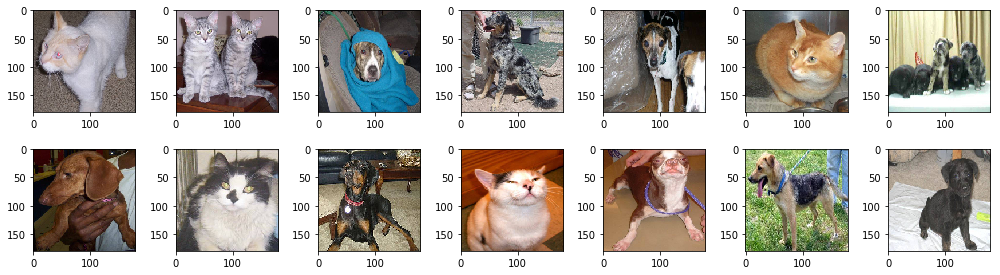

In [96]:
plt.figure(figsize=(14, 4))
for i in range(0, 14):
    plt.subplot(2, 7, i+1)
    for X_batch, Y_batch in o_train_gen:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
orig_model_1 = Model1()
%time orig_model_1.fit_gen(o_train_gen, o_valid_gen, epochs=EPOCH)

-----------------------------------------------------------------
Epochs: 30	| Iterations: 71	| Batch: 256
-----------------------------------------------------------------


In [ ]:
print_test('Original model', orig_model_1)

In [ ]:
plot_curves(f'First model - Accuracy', [orig_model_1.history['acc_train'], orig_model_1.history['acc_valid']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


In [ ]:
plot_curves(f'First model - Loss', [orig_model_1.history['loss_train'], orig_model_1.history['loss_valid']], 'Loss', 'Epoch', ['Train', 'Valid'])


In [ ]:
orig_predicted_proba = orig_model_1.predict_proba(test_data, batch_size = 1024)

In [ ]:
df = predicted_to_df_and_to_file(orig_predicted_proba, 'orig_predicted')
df.head()

# dat augmentation

In [ ]:
aug_data_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=0.15, 
    height_shift_range=0.15, 
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.3,
    shear_range=0.2,
)

aug_train_gen = aug_data_gen.flow_from_directory(f'{prepared_path}/train/', class_mode='binary', batch_size=BATCH_SIZE, target_size=IMG_SIZE)


In [ ]:
plt.figure(figsize=(14, 4))
for i in range(0, 14):
    plt.subplot(2, 7, i+1)
    for X_batch, Y_batch in aug_train_gen:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
aug_model_1 = Model1()
aug_model_1.fit_gen(aug_train_gen, o_valid_gen, epochs=EPOCH)

In [ ]:
print_test('Aug model', aug_model_1)

In [ ]:
plot_curves(f'Aug model - Accuracy', [aug_model_1.history['acc_train'], aug_model_1.history['acc_valid']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


In [ ]:
plot_curves(f'Aug model - Loss', [aug_model_1.history['loss_train'], aug_model_1.history['loss_valid']], 'Loss', 'Epoch', ['Train', 'Valid'])


In [ ]:
aug_predicted_proba = aug_model_1.predict_proba(test_data, batch_size = 1024)

In [ ]:
df = predicted_to_df_and_to_file(orig_predicted_proba, 'aug_predicted')
df.head()

# Transfer Learning

In [ ]:
import tensorflow.keras as keras

In [ ]:
vgg16 = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, CHANNELS))

In [ ]:
vgg16.trainable = True
trainable = False
for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

In [ ]:
vgg16.summary()

In [ ]:
tr_l_model = keras.Sequential()

tr_l_model.add(vgg16)
tr_l_model.add(keras.layers.Flatten())
tr_l_model.add(keras.layers.Dense(256, activation='relu'))
tr_l_model.add(keras.layers.Dropout(0.5))
tr_l_model.add(keras.layers.Dense(64, activation='relu'))
tr_l_model.add(keras.layers.Dropout(0.5))
tr_l_model.add(keras.layers.Dense(1, activation='sigmoid'))

tr_l_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-5), 
              metrics=['accuracy'])

In [ ]:
tr_l_model.summary()

In [ ]:
tr_l_model.fit_generator(
    aug_train_gen,
    steps_per_epoch=len(aug_train_gen),
    epochs=TR_LAERN_EPOCH,
    validation_data=o_valid_gen,
    validation_steps=len(o_valid_gen)
)

In [ ]:
tr_l_loss, tr_l_acc = tr_l_model.evaluate_generator(o_test_gen, steps=len(o_test_gen))
tr_l_loss, tr_l_acc

In [ ]:
print(f'Transfer Learning vgg16: loss - {tr_l_loss:.4f}\t Acc - {tr_l_acc:.02%}')

In [ ]:
plot_curves(f'TR Learning model - Accuracy', [tr_l_model.history.history['acc'], tr_l_model.history.history['val_acc']], 'Accuracy', 'Epoch', ['Train', 'Valid'])


In [ ]:
plot_curves(f'TR Learning model - Loss', [tr_l_model.history.history['loss'], tr_l_model.history.history['val_loss']], 'Loss', 'Epoch', ['Train', 'Valid'])


In [ ]:
tr_l_predicted_proba = tr_l_model.predict_proba(test_data)

In [ ]:
df = predicted_to_df_and_to_file(tr_l_predicted_proba, 'tr_l_predicted')
df.head()